# Images Folder

Your images folder should be at the same level of the RETFoud_MAE cloned folder. 

```
images/
RETFound_MAE/
    └── copy_images.ipynb
```

# Binary copy with (e.g : Messidor-2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, io, random, math, glob, shutil

from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from pathlib import Path
from PIL import Image, ImageEnhance, ImageFilter, ImageOps, ImageDraw, ImageChops

In [2]:
# CSV
df = pd.read_csv("../images/messidor_2/messidor_data.csv")

# Binary classification
df['binary_DR'] = df['diagnosis'].apply(lambda x: 0 if x in [0, 1] else 1)

# Check
df[['id_code', 'diagnosis', 'binary_DR']].head()

,id_code,diagnosis,binary_DR
0,20051020_43808_0100_PP.png,0,0
1,20051020_43832_0100_PP.png,1,0
2,20051020_43882_0100_PP.png,1,0
3,20051020_43906_0100_PP.png,2,1
4,20051020_44261_0100_PP.png,0,0


Total images : 1744

Binary Classes distribution (0 = No/Low DR, 1 = mild to severe DR) :
  • Classe 0: 1287 images (73.8 %)
  • Classe 1: 457 images (26.2 %)


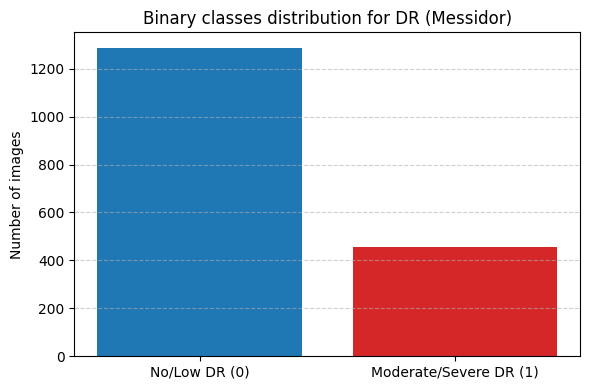

In [3]:
# Stats
distribution = df['binary_DR'].value_counts().sort_index()
total        = len(df)

# Text
print(f"Total images : {total}\n")
print("Binary Classes distribution (0 = No/Low DR, 1 = mild to severe DR) :")
for label, count in distribution.items():
    pct = 100 * count / total
    print(f"  • Classe {label}: {count} images ({pct:.1f} %)")

# Graph
labels = ['No/Low DR (0)', 'Moderate/Severe DR (1)']
counts = distribution.values
percents = 100 * counts / total

plt.figure(figsize=(6,4))
bars = plt.bar(labels, counts, color=['tab:blue', 'tab:red'])

plt.title("Binary classes distribution for DR (Messidor)")
plt.ylabel("Number of images")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

We have imbalanced distribution between class 1 and 0. We may want to try to use over-sampling on class 1 just as we did for the Lamphun dataset before

In [4]:
# Paths
BASE_DIR   = Path("../images/messidor_2")
CSV_PATH   = BASE_DIR / "messidor_data.csv"
DST_ROOT   = Path("data") # RETFound images folder

# Load and binary
df = pd.read_csv(CSV_PATH)
df["binary_DR"] = df["diagnosis"].apply(lambda x: 0 if x in [0, 1] else 1)

# Absolute path if images
df["filepath"] = df["id_code"].apply(lambda f: str(BASE_DIR / f))

In [5]:
SPLIT = {"train": 0.7, "val": 0.2, "test": 0.1}

# Split test (10%) from the full dataset
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=SPLIT["test"], random_state=974)
trainval_idx, test_idx = next(sss1.split(df, df["binary_DR"]))
df_trainval = df.iloc[trainval_idx].reset_index(drop=True)
df_test     = df.iloc[test_idx].reset_index(drop=True)

# Split val (20%) and train (70%) from the trainval
val_ratio = SPLIT["val"] / (SPLIT["train"] + SPLIT["val"])  # = 0.2 / 0.9 ≈ 0.222
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=974)
train_idx, val_idx = next(sss2.split(df_trainval, df_trainval["binary_DR"]))
df_train = df_trainval.iloc[train_idx].reset_index(drop=True)
df_val   = df_trainval.iloc[val_idx].reset_index(drop=True)

# Oversamplimpg the minority class (on training set only)
ros = RandomOverSampler(random_state=974)
X_over, y_over = ros.fit_resample(df_train[["filepath"]], df_train["binary_DR"])
df_train_balanced = df_train.set_index("filepath").loc[X_over["filepath"]].reset_index()
df_train_balanced["binary_DR"] = y_over

In [6]:
print("Train:")
print(df_train_balanced["binary_DR"].value_counts())
print("\nVal:")
print(df_val["binary_DR"].value_counts())
print("\nTest:")
print(df_test["binary_DR"].value_counts())

Train:
binary_DR
0    900
1    900
Name: count, dtype: int64

Val:
binary_DR
0    258
1     91
Name: count, dtype: int64

Test:
binary_DR
0    129
1     46
Name: count, dtype: int64


In [7]:
# Create folder for RETFound classes
for split_name in ["train", "val", "test"]:
    for class_value in [0, 1]:
        class_name = f"{class_value}" if class_value == 0 else f"{class_value}"
        target_dir = os.path.join("./data", split_name, class_name)
        os.makedirs(target_dir, exist_ok=True)

In [8]:
import shutil
from tqdm import tqdm

# New name column for oversampled data
df_train_balanced = df_train_balanced.reset_index(drop=True)
df_train_balanced["new_filename"] = df_train_balanced.index.astype(str) + "_" + df_train_balanced["id_code"]
df_val["new_filename"] = df_val["id_code"]
df_test["new_filename"] = df_test["id_code"]

# Regroup splits
splits = {
    "train": df_train_balanced,
    "val": df_val,
    "test": df_test
}

# Folder per split per class
base_dir = Path("data")
for split_name, df_split in splits.items():
    for class_value in [0, 1]:
        class_name = f"{class_value}" if class_value == 0 else f"{class_value}"
        target_dir = base_dir / split_name / class_name
        target_dir.mkdir(parents=True, exist_ok=True)

# Copy images
for split_name, df_split in splits.items():
    for idx, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Copying {split_name}"):
        class_value = row["binary_DR"]
        class_name = f"{class_value}" if class_value == 0 else f"{class_value}"

        src = Path(row["filepath"])
        dst_filename = row["new_filename"] + src.suffix
        dst = base_dir / split_name / class_name / dst_filename

        if src.exists():
            shutil.copy2(src, dst)
        else:
            print(f"[WARNING] File not found: {src}")

Copying test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 4237.50it/s]


In [9]:
# Path
ROOT = "./data"

# Classes and extension
CLASSES = ["1", "0"]
EXTS = (".jpg", ".jpeg", ".png")

# Collect and count
rows = []
for split in ["train", "val", "test"]:
    split_dir = os.path.join(ROOT, split)
    if not os.path.isdir(split_dir):
        print(f"no folders : {split_dir}")
        continue
        
    total_split = 0
    counts = {}
    for cls in CLASSES:
        pattern = os.path.join(split_dir, cls, "**", "*")
        n_imgs = sum(1 for f in glob.iglob(pattern, recursive=True)
                     if f.lower().endswith(EXTS) and os.path.isfile(f))
        counts[cls] = n_imgs
        total_split += n_imgs

    rows.append({
        "split": split,
        "n_total": total_split,
        **{f"n_{cls}": counts[cls] for cls in CLASSES},
        **{f"%_{cls}": counts[cls] * 100 / total_split if total_split else 0 for cls in CLASSES},
    })

df_counts = pd.DataFrame(rows)
df_counts.set_index("split", inplace=True)
df_counts = df_counts[["n_total"] +
                      [f"n_{c}" for c in CLASSES] +
                      [f"%_{c}" for c in CLASSES]]

display(df_counts.style.format(precision=2))

,n_total,n_1,n_0,%_1,%_0
split,,,,,
train,1800,900,900,50.00,50.00
val,349,91,258,26.07,73.93
test,175,46,129,26.29,73.71


# Multi-class copy (e.g Messidor-2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, io, random, math, glob, shutil

from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from pathlib import Path
from PIL import Image, ImageEnhance, ImageFilter, ImageOps, ImageDraw, ImageChops

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [ ]:
# CSV
df = pd.read_csv("../images/messidor_2/messidor_data.csv")

df

In [ ]:
diagnosis_counts = df['diagnosis'].value_counts().sort_index()

# Print
print("Distribution :")
print(diagnosis_counts)

# Graph
plt.figure(figsize=(8, 6))
bars = plt.bar(diagnosis_counts.index.astype(str), diagnosis_counts.values)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, int(yval), ha='center', va='bottom')

plt.title("Distribution of diagnostic")
plt.xlabel("Diagnostic")
plt.ylabel("Number of images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
for split_name in ["train", "val", "test"]:
    for class_value in range(5):  # classes 0 à 4
        class_name = str(class_value)
        target_dir = os.path.join("./data", split_name, class_name)
        os.makedirs(target_dir, exist_ok=True)

In [ ]:
# Configuration
image_dir = "./images/messidor_2" 
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)
random.seed(974)

# Stratified split 70/20/10
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['diagnosis'], random_state=974)
val_df, test_df = train_test_split(temp_df, test_size=1/3, stratify=temp_df['diagnosis'], random_state=974)

In [ ]:
def augment_image(image_path, save_path):
    img = Image.open(image_path).convert("RGB")
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() < 0.5:
        img = img.rotate(random.uniform(-15, 15))
    contrast = ImageEnhance.Contrast(img)
    img = contrast.enhance(random.uniform(0.8, 1.2))
    img.save(save_path)

In [ ]:
# There so low class 3 and 4 that we are not going to oversampled them all the way to the same number as class 0
# That's why we will be using a moderate oversampling + random images augmentation + weighted classes
oversample_target = {1: 500, 2: 500, 3: 300, 4: 250}
augmented_rows = []

for cls, target in oversample_target.items():
    cls_subset = train_df[train_df["diagnosis"] == cls]
    n_current = len(cls_subset)
    if n_current >= target:
        continue

    needed = target - n_current
    multiplier = needed // n_current
    remainder = needed % n_current

    for i in range(multiplier):
        for _, row in cls_subset.iterrows():
            src = os.path.join(image_dir, row["id_code"])
            base_name, ext = os.path.splitext(row["id_code"])
            new_id = f"{base_name}_aug{i}{ext}"
            dst_dir = os.path.join(output_dir, "train", str(cls))
            os.makedirs(dst_dir, exist_ok=True)
            dst_path = os.path.join(dst_dir, new_id)
            augment_image(src, dst_path)
            new_row = row.copy()
            new_row["id_code"] = new_id
            augmented_rows.append(new_row)

    for _, row in cls_subset.sample(n=remainder, random_state=974).iterrows():
        src = os.path.join(image_dir, row["id_code"])
        base_name, ext = os.path.splitext(row["id_code"])
        new_id = f"{base_name}_augX{ext}"
        dst_dir = os.path.join(output_dir, "train", str(cls))
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, new_id)
        augment_image(src, dst_path)
        new_row = row.copy()
        new_row["id_code"] = new_id
        augmented_rows.append(new_row)


In [ ]:
# Final train (no need to oversample nor images augmentation on val and test)
aug_df = pd.DataFrame(augmented_rows)
train_df_final = pd.concat([train_df, aug_df], ignore_index=True)

In [ ]:
def copy_images_to_class_folders(df_split, split_name):
    for _, row in df_split.iterrows():
        class_dir = os.path.join(output_dir, split_name, str(row["diagnosis"]))
        os.makedirs(class_dir, exist_ok=True)

        src_path = os.path.join(image_dir, row["id_code"])  
        dst_path = os.path.join(class_dir, row["id_code"])  

        if not os.path.exists(dst_path): 
            try:
                shutil.copyfile(src_path, dst_path)
            except FileNotFoundError:
                print(f"File not found : {src_path}")

In [ ]:
# Copy
copy_images_to_class_folders(train_df, "train")
copy_images_to_class_folders(val_df, "val")
copy_images_to_class_folders(test_df, "test")

# Affichage des distributions finales
print("New distribution :")
print("Train :\n", train_df_final["diagnosis"].value_counts().sort_index())
print("Val   :\n", val_df["diagnosis"].value_counts().sort_index())
print("Test  :\n", test_df["diagnosis"].value_counts().sort_index())

Total images : 2051

Binary Classes distribution (0 = No/Low DR, 1 = mild to severe DR) :
  • Classe 0: 1825 images (89.0 %)
  • Classe 1: 226 images (11.0 %)


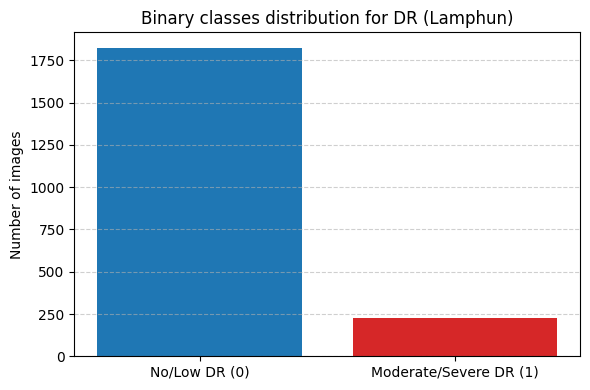

In [52]:
# CSV
df = pd.read_csv("images/lamphun/labelDR_Lamphun_binary_v5.csv")

# Stats
distribution = df["DR_binary"].value_counts().sort_index()
total        = len(df)

# Text
print(f"Total images : {total}\n")
print("Binary Classes distribution (0 = No/Low DR, 1 = mild to severe DR) :")
for label, count in distribution.items():
    pct = 100 * count / total
    print(f"  • Classe {label}: {count} images ({pct:.1f} %)")

# Graph
labels = ['No/Low DR (0)', 'Moderate/Severe DR (1)']
counts = distribution.values
percents = 100 * counts / total

plt.figure(figsize=(6,4))
bars = plt.bar(labels, counts, color=['tab:blue', 'tab:red'])

plt.title("Binary classes distribution for DR (Lamphun)")
plt.ylabel("Number of images")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [53]:
# Paths
BASE_DIR   = Path("./images/lamphun")
CSV_PATH   = BASE_DIR / "labelDR_Lamphun_binary_v5.csv"
DST_ROOT   = Path("RETFound_MAE/data") # RETFound folder

In [54]:
SPLIT = {"train": 0.7, "val": 0.2, "test": 0.1}

# Split test (10%) from the full dataset
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=SPLIT["test"])
trainval_idx, test_idx = next(sss1.split(df, df["DR_binary"]))
df_trainval = df.iloc[trainval_idx].reset_index(drop=True)
df_test     = df.iloc[test_idx].reset_index(drop=True)

# Split val (20%) and train (70%) from the trainval
val_ratio = SPLIT["val"] / (SPLIT["train"] + SPLIT["val"])  # = 0.2 / 0.9 ≈ 0.222
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio)
train_idx, val_idx = next(sss2.split(df_trainval, df_trainval["DR_binary"]))
df_train = df_trainval.iloc[train_idx].reset_index(drop=True)
df_val   = df_trainval.iloc[val_idx].reset_index(drop=True)

# Oversamplimpg the minority class (on training set only)
ros = RandomOverSampler()
X_over, y_over = ros.fit_resample(df_train[["filepath"]], df_train["DR_binary"])
df_train_balanced = df_train.set_index("filepath").loc[X_over["filepath"]].reset_index()
df_train_balanced["DR_binary"] = y_over

In [55]:
# Mark dupes created by ROS
df_train_balanced["is_oversample"] = df_train_balanced.duplicated(
    subset="filepath", keep="first"
)

# new filename
for d in (df_train_balanced, df_val, df_test):
    d.reset_index(drop=True, inplace=True)
    d["new_filename"] = d.index.astype(str) + "_" + d["filepath"].apply(lambda p: Path(p).stem)

In [56]:
def random_augment(img: Image.Image) -> Image.Image:
    
    def random_affine(im):
        angle  = random.uniform(-5, 5)
        scale  = random.uniform(0.92, 1.08)
        tx     = random.uniform(-0.05, 0.05) * im.size[0]
        ty     = random.uniform(-0.05, 0.05) * im.size[1]
        return im.transform(
            im.size, Image.AFFINE,
            (scale*math.cos(math.radians(angle)),
             -math.sin(math.radians(angle)), tx,
             math.sin(math.radians(angle)),
             scale*math.cos(math.radians(angle)), ty),
            resample=Image.BILINEAR
        )

    def random_zoom_in(im):
        w, h = im.size
        crop_ratio = random.uniform(0.9, 1.0)
        nw, nh = int(w*crop_ratio), int(h*crop_ratio)
        left = random.randint(0, w-nw)
        top  = random.randint(0, h-nh)
        return im.crop((left, top, left+nw, top+nh)).resize((w, h), Image.BILINEAR)

    def add_gaussian_noise(im):
        arr = np.array(im).astype(np.int16)
        noise = np.random.normal(0, random.uniform(2,5), arr.shape)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(arr)

    def cutout(im):
        draw = ImageDraw.Draw(im)
        w, h = im.size
        sz = random.randint(20, 40)
        x0 = random.randint(0, w-sz)
        y0 = random.randint(0, h-sz)
        draw.rectangle([x0, y0, x0+sz, y0+sz], fill=(0,0,0))
        return im

    def gamma_shift(im):
        gamma = random.uniform(0.9, 1.1)
        lut   = [pow(x/255., gamma)*255 for x in range(256)]
        return im.point(lut * (3 if im.mode == "RGB" else 1))

    def hue_sat_jitter(im):
        return ImageEnhance.Color(im).enhance(random.uniform(0.9, 1.1))

    def vignette(im):
        w, h = im.size
        mask = Image.new("L", (w, h), 255)
        draw = ImageDraw.Draw(mask)
        max_radius = int(math.hypot(w, h) / 2)
        for r in range(max_radius, 0, -4):
            shade = int(255 * (1 - (r / max_radius) ** 2))
            draw.ellipse([(w/2 - r, h/2 - r), (w/2 + r, h/2 + r)], fill=shade)
        mask = mask.resize(im.size, Image.LANCZOS)
        return ImageChops.multiply(im, Image.merge("RGB", [mask] * 3))

    ops = [
        lambda im: ImageOps.mirror(im),
        lambda im: ImageOps.flip(im),
        lambda im: im.rotate(random.choice([90, 180, 270])),
        lambda im: ImageEnhance.Brightness(im).enhance(random.uniform(0.85, 1.15)),
        lambda im: ImageEnhance.Contrast(im).enhance(random.uniform(0.85, 1.15)),
        lambda im: im.filter(ImageFilter.GaussianBlur(radius=1)),
        random_affine,
        random_zoom_in,
        gamma_shift,
        hue_sat_jitter,
        add_gaussian_noise,
        cutout,
        vignette,
    ]
    return random.choice(ops)(img)

In [57]:
print("Train:")
print(df_train_balanced["DR_binary"].value_counts())
print("\nVal:")
print(df_val["DR_binary"].value_counts())
print("\nTest:")
print(df_test["DR_binary"].value_counts())

Train:
DR_binary
1    1276
0    1276
Name: count, dtype: int64

Val:
DR_binary
0    366
1     45
Name: count, dtype: int64

Test:
DR_binary
0    183
1     23
Name: count, dtype: int64


In [58]:
# Create folder for RETFound classes
for split_name in ["train", "val", "test"]:
    for class_value in [0, 1]:
        class_name = f"{class_value}_noDR" if class_value == 0 else f"{class_value}_DR"
        target_dir = os.path.join("./RETFound_MAE/data", split_name, class_name)
        os.makedirs(target_dir, exist_ok=True)

In [59]:
# Regroup splits
splits = {
    "train": df_train_balanced,
    "val": df_val,
    "test": df_test
}

# Folder per split per class
base_dir = Path("RETFound_MAE/data")
for split_name, df_split in splits.items():
    for _, row in tqdm(df_split.iterrows(), total=len(df_split),
                       desc=f"Copy {split_name}"):
        cls_folder = f"{row.DR_binary}_{'noDR' if row.DR_binary == 0 else 'DR'}"
        src_path = Path(row.filepath)
        if not src_path.exists():
            print(f"[WARN] missing : {src_path}")
            continue

        # Nom final + extension
        dst_name = f"{row.new_filename}{src_path.suffix}"
        dst_path = base_dir / split_name / cls_folder / dst_name

        # ----------------------------------------------------
        # TRAIN SET
        #   - class 1, duplicate row   => 1 image : augmented version
        #   - classe 1, original row   => raw copy
        #   - classe 0                    => raw copy
        # ----------------------------------------------------
        if (
            split_name == "train"
            and row.DR_binary == 1
            and row.is_oversample # ROS flag
        ):
            # skip raw copy and keep only the augmented one of the dupe
            try:
                img_aug = random_augment(Image.open(src_path))
                aug_dst_path = dst_path.with_stem(dst_path.stem + "_aug")
                img_aug.save(aug_dst_path)
            except Exception as e:
                print(f"[AUG-FAIL] {src_path} : {e}")
        else:
            # not a dupe -> raw copy
            shutil.copy2(src_path, dst_path)

Copy test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 2342.18it/s]


In [60]:
# Path
ROOT = "./RETFound_MAE/data"

# Classes and extension
CLASSES = ["1_DR", "0_noDR"]
EXTS = (".jpg", ".jpeg", ".png")

# Collect and count
rows = []
for split in ["train", "val", "test"]:
    split_dir = os.path.join(ROOT, split)
    if not os.path.isdir(split_dir):
        print(f"no folders : {split_dir}")
        continue
        
    total_split = 0
    counts = {}
    for cls in CLASSES:
        pattern = os.path.join(split_dir, cls, "**", "*")
        n_imgs = sum(1 for f in glob.iglob(pattern, recursive=True)
                     if f.lower().endswith(EXTS) and os.path.isfile(f))
        counts[cls] = n_imgs
        total_split += n_imgs

    rows.append({
        "split": split,
        "n_total": total_split,
        **{f"n_{cls}": counts[cls] for cls in CLASSES},
        **{f"%_{cls}": counts[cls] * 100 / total_split if total_split else 0 for cls in CLASSES},
    })

df_counts = pd.DataFrame(rows)
df_counts.set_index("split", inplace=True)
df_counts = df_counts[["n_total"] +
                      [f"n_{c}" for c in CLASSES] +
                      [f"%_{c}" for c in CLASSES]]

display(df_counts.style.format(precision=2))

,n_total,n_1_DR,n_0_noDR,%_1_DR,%_0_noDR
split,,,,,
train,2552,1276,1276,50.00,50.00
val,411,45,366,10.95,89.05
test,206,23,183,11.17,88.83


In [92]:
def show_random_train_images(base_dir="RETFound_MAE/data/train", class_subfolder="1_DR",n=12, seed=None):
    base_dir = Path(base_dir)
    # limit the search only in class 1 folder
    search_dir = base_dir / class_subfolder

    if seed is not None:
        random.seed(seed)

    exts = {".jpg", ".jpeg", ".png"}
    all_paths = [p for p in search_dir.rglob("*") if p.suffix.lower() in exts]
    if not all_paths:
        raise RuntimeError(f"No image found under {search_dir.resolve()}")

    sample_paths = random.sample(all_paths, min(n, len(all_paths)))

    # Figure
    cols = 4
    rows = math.ceil(n / cols)
    plt.figure(figsize=(3.5 * cols, 3.5 * rows))

    for idx, img_path in enumerate(sample_paths, 1):
        img = Image.open(img_path)

        # Detect augmentation
        is_aug = img_path.stem.endswith("_aug") or "_aug" in img_path.stem
        aug_flag = " (aug)" if is_aug else " (orig)"

        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        plt.title(f"{class_subfolder}{aug_flag}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

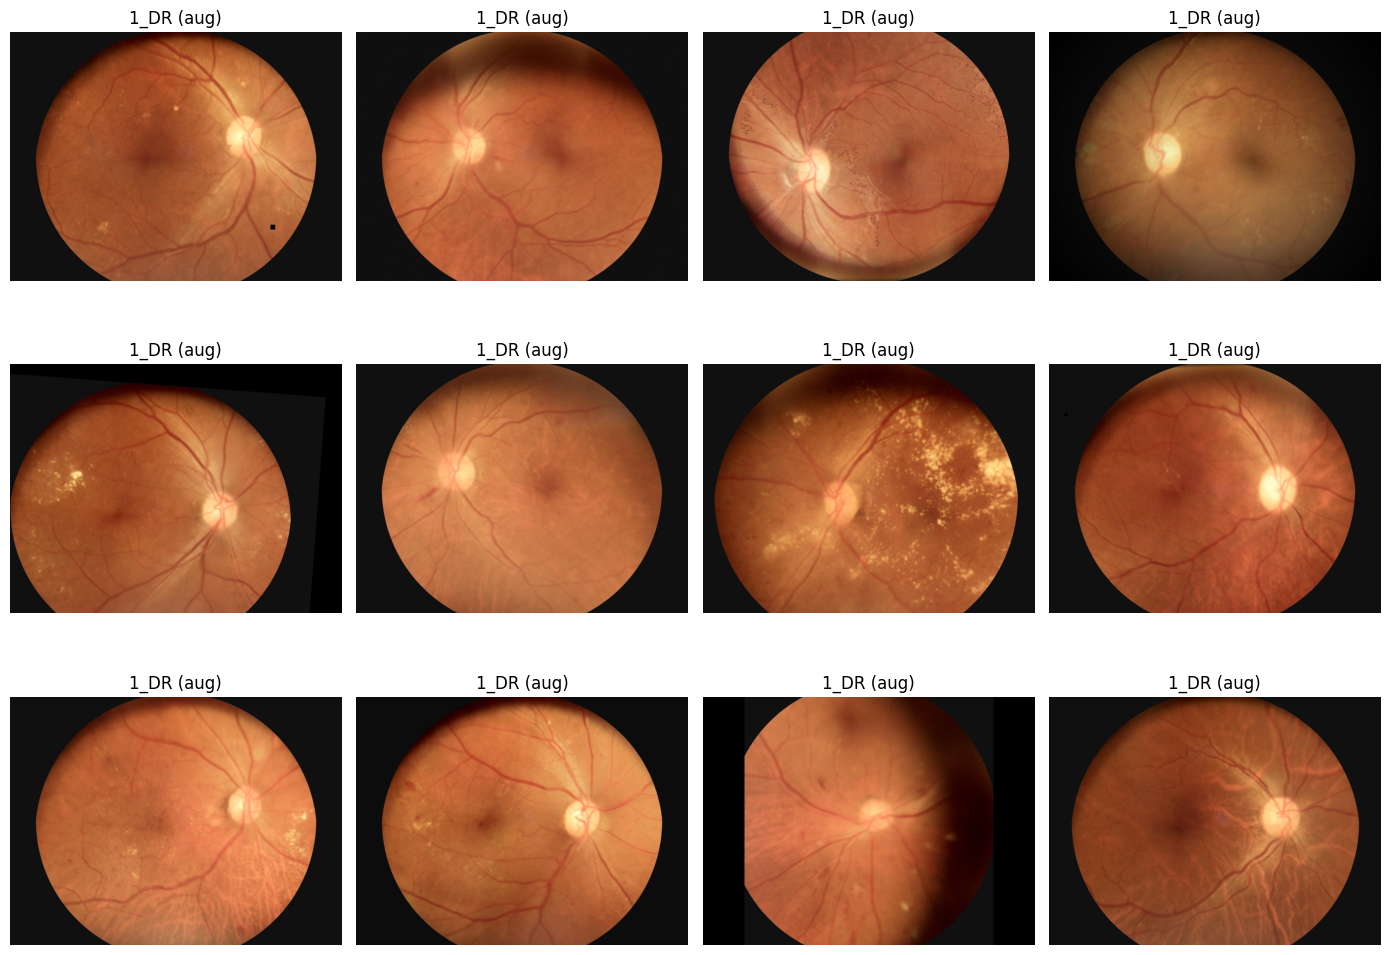

In [93]:
show_random_train_images()

# Unlabelled data copy for inference

The following code is used to copy unlabelled data into RETFound_MAE/data/test/dummy to make prediction by a fine-tuned model.

In [2]:
import os
import shutil
from tqdm import tqdm

# Source folder with unlabelled images
src_dir = "../images/chula/10k_images"

# Create folders for RETFound classes
splits = ["train", "val", "test"]
for split_name in splits:
    target_dir = os.path.join("./data", split_name, "dummy")
    os.makedirs(target_dir, exist_ok=True)

# Destination for bulk copy
test_dst_dir = "./data/test/dummy"

# List all image files
image_files = sorted([
    f for f in os.listdir(src_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

print(f"Number of images found : {len(image_files)}")

# Copy ALL images to test/dummy
for filename in tqdm(image_files, desc="Copy to test"):
    src_path = os.path.join(src_dir, filename)
    dst_path = os.path.join(test_dst_dir, filename)
    shutil.copy2(src_path, dst_path)

# Copy one image to train/dummy and another to val/dummy
if len(image_files) >= 2:
    shutil.copy2(os.path.join(src_dir, image_files[0]),
                 os.path.join("./data/train/dummy", image_files[0]))
    
    shutil.copy2(os.path.join(src_dir, image_files[1]),
                 os.path.join("./data/val/dummy", image_files[1]))
    print("1 image copied to train/dummy and 1 to val/dummy.")
else:
    print("Not enough images to copy to train and val.")

print("Done.")

Number of images found : 135


Copy: 100%|█████████████████████████████████████████████████████| 135/135 [00:00<00:00, 2486.65it/s]

Done.
